# Projekt
Analiza ryzyka portfela inwestycyjnego cen ropy i gazu ziemnego. Żródło danych: https://www.kaggle.com/datasets/raspberrypie/oil-and-gas.

In [1]:
# pip install numpy pandas seaborn matplotlib yfinance pymannkendall statsmodels scipy sklarpy copulas pingouin
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import yfinance as yf
import pymannkendall as mk
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm, lognorm, kstest, shapiro, t, pearsonr, kendalltau, spearmanr
from sklarpy.copulas import student_t_copula, gaussian_copula, clayton_copula, gumbel_copula, frank_copula
import warnings
warnings.filterwarnings("ignore")
from sklarpy.univariate import student_t
from copulas.univariate import (
    GaussianUnivariate,
    GaussianKDE,
    BetaUnivariate,
    GammaUnivariate,
    StudentTUnivariate,
    LogLaplace,
    TruncatedGaussian,
    UniformUnivariate
)
from copulas.univariate.selection import select_univariate
from copulas.multivariate import GaussianMultivariate
from copulas.bivariate import Clayton, Gumbel, Frank
from copulas.bivariate import select_copula
from pingouin import multivariate_normality
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2

## Pobranie zestawu danych z Kaggle

In [2]:
# pip install kagglehub
# import kagglehub

# path = kagglehub.dataset_download("prasertk/historical-daily-oil-and-natural-gas-prices")
# print("Path to dataset files:", path)

In [44]:
data = pd.read_csv('data\oil_and_gas.csv', parse_dates=['Date'])
data.head()

,Symbol,Date,Open,High,Low,Close,Volume,Currency
0,Brent Oil,2000-01-04,23.90,24.70,23.89,24.39,32509,USD
1,Brent Oil,2000-01-05,24.25,24.37,23.70,23.73,30310,USD
2,Brent Oil,2000-01-06,23.55,24.22,23.35,23.62,44662,USD
3,Brent Oil,2000-01-07,23.57,23.98,23.05,23.09,34826,USD
4,Brent Oil,2000-01-10,23.04,23.78,23.04,23.73,26388,USD


In [45]:
pd.unique(data['Currency'])

array(['USD'], dtype=object)

In [46]:
pd.unique(data['Symbol'])

array(['Brent Oil', 'Crude Oil WTI', 'Natural Gas', 'Heating Oil'],
      dtype=object)

Zmieniamy formę danych tak, że:
- indeks to unikalne daty z kolumny `Date`,
- nowe kolumny to unikalne wartości z kolumny `Symbol`,
- wiersze zawierają wartości z kolumny `Close`, przypisane do odpowiednich symboli.

In [47]:
data = data.pivot(index='Date', columns='Symbol', values='Close')[['Brent Oil', 'Natural Gas']]

Zmieniamy nazwy kolumn:

In [48]:
data.columns = ['Oil', 'Gas']
data.head()

,Oil,Gas
Date,,
2000-01-04,24.39,2.176
2000-01-05,23.73,2.168
2000-01-06,23.62,2.196
2000-01-07,23.09,2.173
2000-01-10,23.73,2.216


In [49]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5843 entries, 2000-01-04 to 2022-06-17
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Oil     5768 non-null   float64
 1   Gas     5742 non-null   float64
dtypes: float64(2)
memory usage: 136.9 KB
None


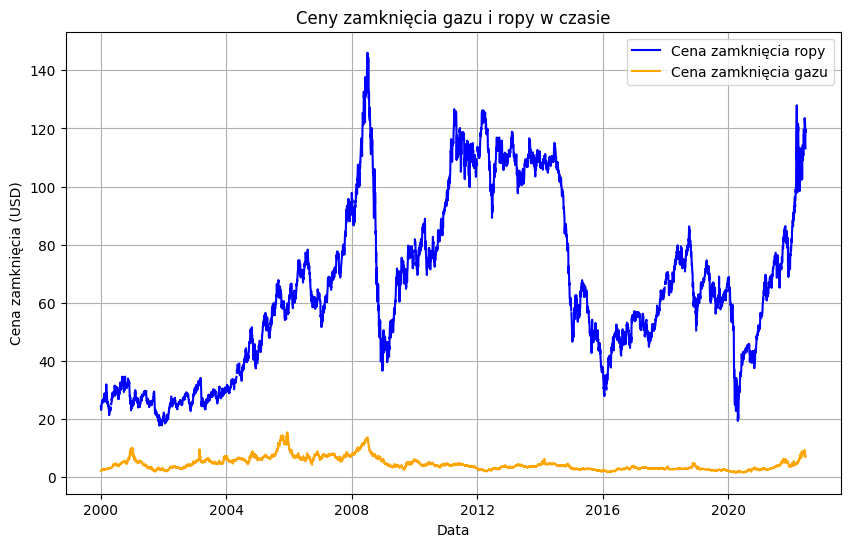

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Oil'], color='blue', label="Cena zamknięcia ropy")
plt.plot(data.index, data['Gas'], color='orange', label="Cena zamknięcia gazu")
plt.xlabel("Data")
plt.ylabel("Cena zamknięcia (USD)")
plt.title("Ceny zamknięcia gazu i ropy w czasie")
plt.legend()
plt.grid()
plt.show()

In [51]:
data.index.to_series().diff().value_counts()

Date
1 days    4660
3 days    1099
2 days      45
4 days      37
5 days       1
Name: count, dtype: int64

In [52]:
print(data.describe())

               Oil          Gas
count  5768.000000  5742.000000
mean     65.315484     4.481384
std      29.383222     2.216018
min      17.680000     1.482000
25%      42.720000     2.854000
50%      62.335000     3.872000
75%      84.062500     5.565000
max     146.080000    15.378000


## Zróżnicowanie szeregów czasowych

In [53]:
data["diff_oil"] = data["Oil"].diff()
data["diff_gas"] = data["Gas"].diff()
data = data.dropna()

In [54]:
print(data[["diff_oil","diff_gas"]].describe())

          diff_oil     diff_gas
count  5520.000000  5520.000000
mean      0.011681     0.000516
std       1.431141     0.185007
min     -16.840000    -1.648000
25%      -0.640000    -0.070000
50%       0.060000     0.000000
75%       0.720000     0.069000
max      10.150000     2.531000


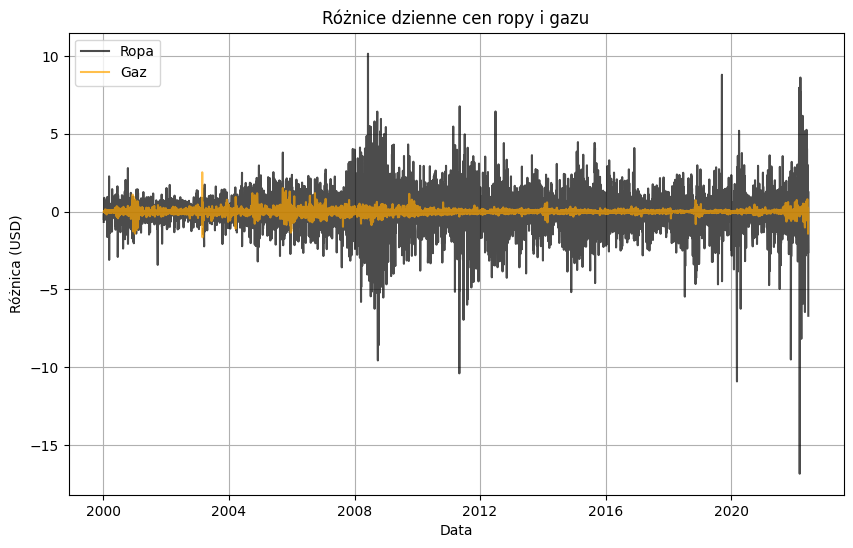

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data["diff_oil"], label="Ropa", color="black", alpha=0.7)
plt.plot(data.index, data["diff_gas"], label="Gaz", color="orange", alpha=0.7)
plt.title("Różnice dzienne cen ropy i gazu")
plt.xlabel("Data")
plt.ylabel("Różnica (USD)")
plt.legend()
plt.grid(True)
plt.show()

## Dopasowanie rozkładów

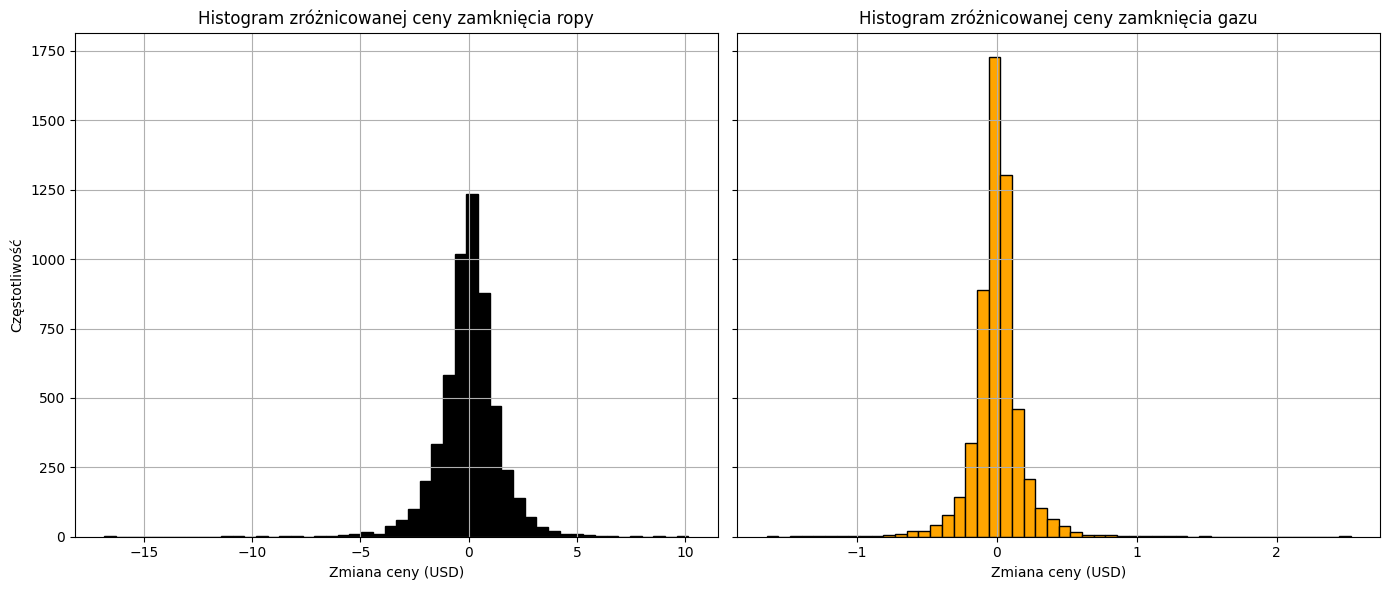

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].hist(data["diff_oil"], bins=50, edgecolor='k', color='black')
axes[0].set_title("Histogram zróżnicowanej ceny zamknięcia ropy")
axes[0].set_xlabel("Zmiana ceny (USD)")
axes[0].set_ylabel("Częstotliwość")
axes[0].grid(True)

axes[1].hist(data["diff_gas"], bins=50, edgecolor='k', color='orange')
axes[1].set_title("Histogram zróżnicowanej ceny zamknięcia gazu")
axes[1].set_xlabel("Zmiana ceny (USD)")
axes[1].grid(True)

plt.tight_layout()
plt.show()